## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing necessary libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# I have downloaded few libraries 
# importing necessary dependent libraries.
#import nltk.corpus
#nltk.download('universal_tagset')
#nltk.download('punkt')



## Reading the Dataset

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

# Check the sample data
print(nltk_data[:1])

#Length of dataset
print('\n','Length of Dataset is : ',len(nltk_data))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]]

 Length of Dataset is :  3914


As mentioned in the problem statement, the train data is divided into 95:5 train and validation data sets

In [4]:
#Splitting into train and validation data sets
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05,random_state=1)

print("Length of train set: ",len(train_set))
print("Length of Validation set: ",len(validation_set))

Length of train set:  3718
Length of Validation set:  196


Lets analyze the Train and validation data sets

In [5]:
#Training Data
train_tagged_words = [tup for sent in train_set for tup in sent]
print('Length of Train set words',len(train_tagged_words))

Length of Train set words 95668


Now lets analyze the vocaubulary words and tags from the train set.

In [6]:
#convert all the words into lower case.
words = [pair[0].lower() for pair in train_tagged_words]

#display sample words
print(words[:5])

#Vocabulary words
vocab_words = set(words)

#finding out the number of unique words
print('vocabulary words in train_set are:',len(vocab_words))

# Now check the tags in the train dataset
tags = set([pair[1] for pair in train_tagged_words])
print("There are {} tags in train_set and they are {}. \n".format(len(tags),tags))

['he', 'has', 'promised', 'stiffer', 'fines']
vocabulary words in train_set are: 11104
There are 12 tags in train_set and they are {'CONJ', 'NOUN', 'PRT', 'ADJ', '.', 'X', 'PRON', 'VERB', 'ADV', 'DET', 'ADP', 'NUM'}. 



In [7]:
# validation Data
validation_tagged_words = [tup for sent in validation_set for tup in sent]
print('Length of validation set words',len(validation_tagged_words))

Length of validation set words 5008


In [8]:
#convert all the words into lower case.
words_validation = [pair[0].lower() for pair in validation_tagged_words]

#display sample words
print(words_validation[:5])

#Vocabulary words
vocab_words_validation = set(words_validation)

#finding out the number of unique words
print('vocabulary words in train_set are:',len(vocab_words_validation))

# Now check the tags in the train dataset
tags_validation = set([pair[1] for pair in validation_tagged_words])
print("There are {} tags in train_set and they are {}. \n".format(len(tags_validation),tags_validation))

['while', 'the', 'new', 'proposal', 'might']
vocabulary words in train_set are: 1780
There are 12 tags in train_set and they are {'NOUN', 'NUM', 'PRT', 'ADJ', '.', 'X', 'PRON', 'VERB', 'ADV', 'DET', 'ADP', 'CONJ'}. 



Lets read the test data as provided in the assignment

In [9]:
#Read and store the test data
testData = open('Test_sentences.txt')
test_data = testData.read()

#Tokenize the read file
test_set = word_tokenize(test_data)

# COnverting the words in lower case format as it will be easy to compare 
test_set = [w.lower() for w in test_set]

#read the sample test data
test_set[:5]

['android', 'is', 'a', 'mobile', 'operating']

Lets check the tag words in the entire data set

In [10]:
#Check the tags in overall dataset
tagged_words_all = [tup for sent in nltk_data for tup in sent]
tags_all = [pair[1] for pair in tagged_words_all]
tag_counts_all = Counter(tags_all)

#Print the counts in sorted order
print(sorted(tag_counts_all.items(), key = lambda kv:(kv[1], kv[0])))

[('CONJ', 2265), ('PRON', 2737), ('ADV', 3171), ('PRT', 3219), ('NUM', 3546), ('ADJ', 6397), ('X', 6613), ('DET', 8725), ('ADP', 9857), ('.', 11715), ('VERB', 13564), ('NOUN', 28867)]


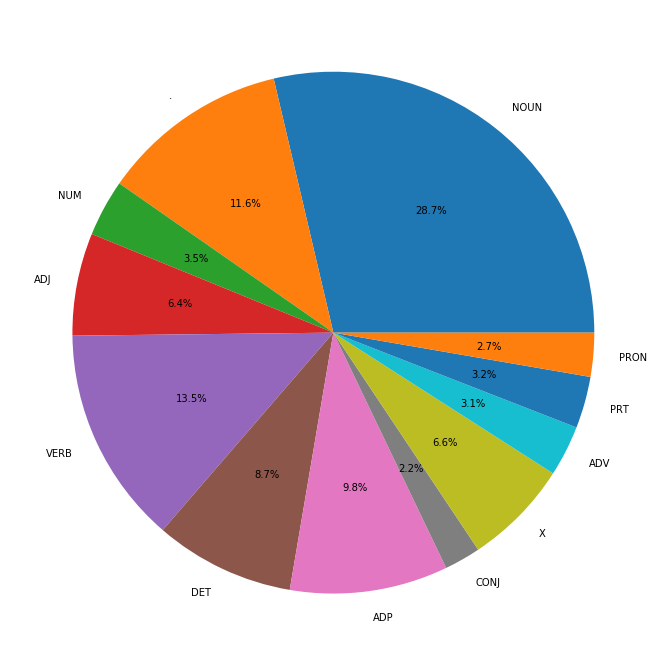

In [11]:
#Lets plot the count of tags and check it?
plt.figure(figsize=(12,12))
plt.pie(list(tag_counts_all.values()), labels=list(tag_counts_all.keys()), autopct='%1.1f%%');



From the above, We can see that there are about 29% of the words occupies with Noun followed by ~14% Verb. Hence Noun is the frequent tag in the collection.

## POS Tagging Algorithm

In this section I will use the HMM algorithm to tag the words.
The prime task is to assign the most probable tag to the word in the given sentence. 

Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

*P(t/w) = P(w/t). P(t) / P(w)*

From the above, we can ignore the P(w), and we have to compute the  P(w/t) and P(t).

We will be implementing Viterbi Algorithm, We need to compte Emission and Transition Probabilities., In other words, 
Emmission Probability is P(w/t) and Transisition Probability is P(t)

Here w represents word and t represents tag.

In [12]:
#Computing the probability of word given tag
#defining the function for emmission Probability
def emission_probability(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    emission_probability = count_w_given_tag/count_tag
    return (count_w_given_tag, count_tag, emission_probability)

Checking the emmission probability for few sample words in the test data

In [13]:
print('Emission Probability for Android as Noun:',emission_probability('Andriod','NOUN')[2])
print('Emission Probability for News as Noun:',emission_probability('news','NOUN')[2])
print('Emission Probability for News as verb:',emission_probability('news','VERB')[2])

Emission Probability for Android as Noun: 0.0
Emission Probability for News as Noun: 0.0008007570794205431
Emission Probability for News as verb: 0.0


From the above, Emmission probability took two arguments and looks like it is working as expected. 

Now, Lets create a function for the transition probability which takes again two paramters. 

In [14]:
#computing probability of tag 2 given tag 1 
def transition_probability(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    transition_prob = count_t2_t1/count_t1
    return (count_t2_t1, count_t1,transition_prob)

In [15]:
#Testing the transition probability on test data with one sample 
print("There are {} mentions of CONJ(t1) before VERB(t2) and {} mentions of Verb(t1).\nTransition probability:{} ".format(transition_probability(t2='VERB',t1='CONJ')[0],transition_probability(t2='VERB',t1='CONJ')[1],transition_probability(t2='VERB',t1='CONJ')[2]))

There are 332 mentions of CONJ(t1) before VERB(t2) and 2148 mentions of Verb(t1).
Transition probability:0.15456238361266295 


From the above, Transition Probability takes two arguments t2 and t1 and looks fine. 

Lets calculate the transition matrix for the tags in combination.

In [16]:
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = transition_probability(t2, t1)[0]/transition_probability(t2, t1)[1]
        if (tags_matrix[i, j]==0):
            print(i,j)
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,CONJ,NOUN,PRT,ADJ,.,X,PRON,VERB,ADV,DET,ADP,NUM
CONJ,0.000466,0.349628,0.004190,0.121974,0.035382,0.008845,0.059590,0.154562,0.054469,0.120577,0.049814,0.040503
NOUN,0.042331,0.264286,0.044224,0.012011,0.240045,0.029228,0.004768,0.146975,0.016743,0.013394,0.176531,0.009463
PRT,0.002280,0.246254,0.001954,0.085993,0.043648,0.014007,0.018241,0.400326,0.010098,0.101629,0.019544,0.056026
ADJ,0.016985,0.700033,0.010884,0.067282,0.064479,0.021108,0.000660,0.011544,0.004782,0.004947,0.076022,0.021273
.,0.058185,0.222342,0.002062,0.043930,0.092254,0.027703,0.065806,0.088757,0.052537,0.172136,0.092433,0.081764
X,0.010491,0.062947,0.185344,0.016532,0.163726,0.074869,0.055158,0.203942,0.025433,0.055317,0.143538,0.002702
PRON,0.004985,0.212040,0.013037,0.072853,0.040261,0.093942,0.006902,0.480828,0.035276,0.009586,0.023006,0.007285
VERB,0.005442,0.111085,0.031250,0.064599,0.035370,0.216807,0.036070,0.168688,0.081468,0.135728,0.090874,0.022621
ADV,0.006327,0.031635,0.013986,0.128538,0.138528,0.022977,0.015318,0.346653,0.078921,0.068931,0.116550,0.031635
DET,0.000482,0.638896,0.000241,0.204847,0.018085,0.045696,0.003497,0.038944,0.012539,0.005305,0.009163,0.022305


In [17]:
#checking transition matrix 
tags_df.min().min()
tags_df['NUM']['NUM']

0.18487646

From the above, it looks fine with the above lookup matrix with the tags.

Now since we have defined both Emission and Transition Probablities now lets proceed to define the Viterbi Algorithm.

The basic notion of Viterbi Algorithm is:

P(Tj | Wi) = P(Wi | Tj) * P(Tj | Tj-1)

Where Tj is the current tag
      Wi is the current word
      Tj-1 is the previous tag

This likelihood function is called state probability and can be written as: state_probability = transition_probability * emission_probability.

That's what we will do in the Viterbi Algorithm defined below.

Lets draw heat map between the Dataframe

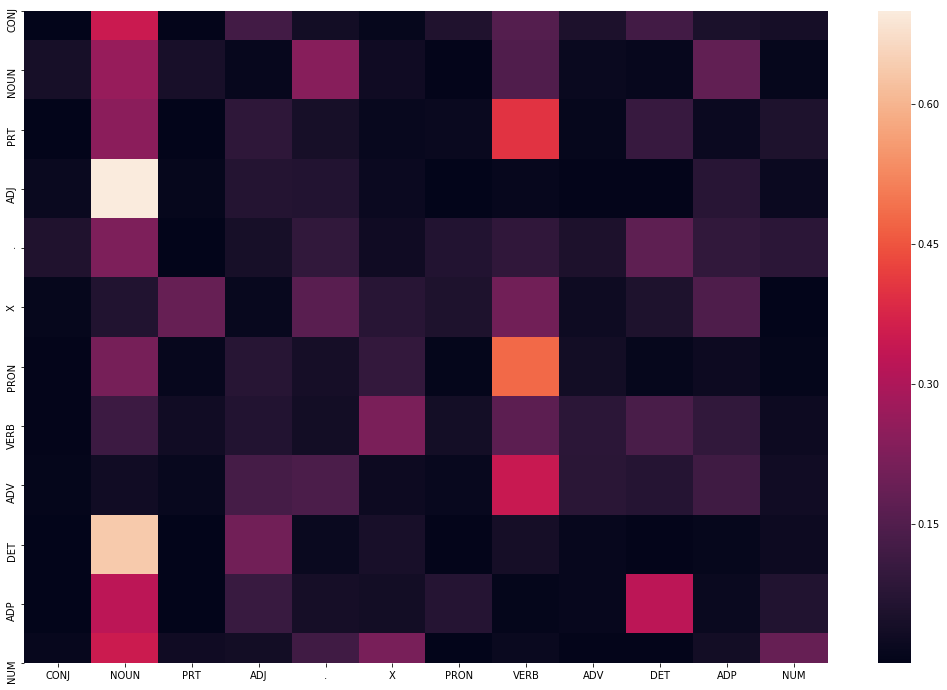

In [18]:
# heat map of the tag words
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [19]:
# creating Viterbi function 
def Viterbi(words, method, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    T.sort(reverse=True)
    print("Default tag list is: ", T)

    unknown_words=[]
    
    known_words = list(set([pair[0] for pair in train_bag]))

    for w in words:
        if w not in known_words:
            unknown_words.append(w)

    print("Number of KNOWN words in this run are:",len(known_words))
    print("Number of Unknown words in this run are:",len(unknown_words))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
           
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]   
                
            emission_p = float(emission_probability(words[key], tag)[2])

            state_probability = emission_p * transition_p 

            p.append(state_probability)
        
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        state.append(state_max)

    tag_seq = list(zip(words, state))
    print("Tagged Unknown Words are: ")
    for i in range(len(tag_seq)):
        if tag_seq[i][0] in unknown_words:
            print(tag_seq[i])
    return tag_seq

We have defined the viterbi Algorithm, now we will proceed with the Vanilla algorithm on the test test. 

We will be using 2 algorithms:
    
    1)Viterbi - Viterbi Vanilla is not able to handle  
    
    2) Viterbi Modified - Basic Viterbi code is modified to handle the Unknown words.

We will use three methods to tests out the unknown words tagging:

    1) Laplace Smoothing
    
    2) Rule based Tagging

    3) ngram_tagger - using ngram technique to handle unknown words. 

In [20]:
# Considering the two methods  to make methods and accuracy of the methods
method_list=[]
accuracy_list=[]

#creating a function to handle the unknown words which takes two arguments.
def validation_testing(algorithm,method):
    # the complete algorithm takes 3 to 4 hours to run. 
    random.seed(1234)

    #Choosing random 5 sentences
    rndom = [random.randint(1,len(validation_set)) for x in range(5)]
    validation_run = [validation_set[i] for i in rndom]
    
    #List of Word-tags in those sentences for accuracy calculation later
    validation_run_base = [tup for sent in validation_run for tup in sent]

    #List of words
    validation_tagged_words = [tup[0] for sent in validation_run for tup in sent]
    
    #Start time
    start = time.time()

    #Actual Tagging
    validation_seq = algorithm((validation_tagged_words),method)

    #End Time
    end = time.time()

    #Actual execution time
    difference = end-start

    print("Time taken to run the task: ", difference)

    # Calculate the accuarcy
    #Check the word-tags in the validation_set against the word-tag as predicted by Viterbi
    check = [i for i, j in zip(validation_seq, validation_run_base) if i == j] 

    #Accuracy
    accuracy = round((len(check)/len(validation_seq))*100)
    print('Prediction of Accuracy in Validation set is {}% '.format(accuracy))
    
    #Append the method and accuracy to the list
    method_list.append(method)
    accuracy_list.append(accuracy)

In [21]:
# Checking the Viterbi vanilla method on Validation set
validation_testing(Viterbi,'Vanilla')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 10
Tagged Unknown Words are: 
('seven-yen', 'X')
('pledged', 'X')
('modernization', 'X')
('impeding', 'X')
('*T*-117', 'X')
('Jennison', 'X')
('7.79', 'X')
('7.52', 'X')
('7.60', 'X')
('suddenly', 'X')
Time taken to run the task:  15.510029077529907
Prediction of Accuracy in Validation set is 87% 


In [22]:
# Creating function to verify the Algorithm and method in the test data set
def test_testing(algorithm,method):
    #Check the start and End Time for execution
    start = time.time()

    #Test the Vanilla Viterbi on test Set
    test_sequence = algorithm(test_set,method)
    print("\nTagged words in the Test Set are:\n")
    print(test_sequence)

    #End time
    end = time.time()

    #Time taken
    difference = end-start
    print("Time taken for executing the Algorithm in test set: ", difference)

In [23]:
#Test Viterbi algorithm on Vanilla method on test set
test_testing(Viterbi,'Vanilla')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 49
Tagged Unknown Words are: 
('android', 'X')
('google', 'X')
('android', 'X')
('os', 'X')
('worldwide', 'X')
('smartphones', 'X')
('2011', 'X')
('2013', 'X')
('google', 'X')
('twitter', 'X')
('2015', 'X')
('google', 'X')
('twitter', 'X')
('firehose', 'X')
('twitter', 'X')
('online', 'X')
('interact', 'X')
('messages', 'X')
('tweets', 'X')
('donald', 'X')
('trump', 'X')
('domineering', 'X')
('personality', 'X')
('2018', 'X')
('fifa', 'X')
('cup', 'X')
('21st', 'X')
('fifa', 'X')
('cup', 'X')
('tournament', 'X')
('contested', 'X')
('cup', 'X')
('eastern', 'X')
('europe', 'X')
('europe', 'X')
('trips', 'X')
('dallas', 'X')
('atlanta', 'X')
('i', 'X')
('denver', 'X')
('philadelphia', 'X')
('atlanta', 'X')
('arriving', 'X')
('san', 'X')
('francisco', 'X')
('nasa', 'X')
('invited', 'X')
('icesat-2', 

## Modified Viterbi Algorithm

In [24]:
# modifying the Viterbi Algorithm. In this modification we are passing one additional input parameter to handle the unknown words

def Viterbi_modified(words,method, n=2,train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))

    T.sort(reverse=True)
    print("Default tag list is: ", T)
    
    unknown_words=[]
    
    #Check for vocab words / known words
    known_words = list(set([pair[0] for pair in train_bag]))

    for w in words:
        if w not in known_words:
            unknown_words.append(w)
            
    #Check number of known words and Unknown words in the run
    print("Number of KNOWN words are:",len(known_words))
    print("Number of Unknown words are:",len(unknown_words))
    print('Method used for tagging Unknown Words is:', method)
    
   
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            # computing the transition Probabilites
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]   
                
            #Computing  Emission probabilities
           
            emission_p = float(emission_probability(words[key], tag)[2])
            
            if(method=='laplace_smoothing'):
                if(emission_p==0):
                    emission_p = float((emission_probability(words[key], tag)[0] + 1)/ + (emission_probability(words[key], tag)[1] + len(train_bag)))
            
            #Calculating  state probabilities
            state_probability = emission_p * transition_p 
            
            p.append(state_probability)
        
        pmax = max(p)
        if pmax ==0.0:
            #methods to handle unknown words
            #ngram Tagger
            if(method=='ngram_Tagger'):
                state_max = ngram_Tagger(words[key],n=n)
                #Rule Based tagger
            elif(method=='rule_tagger'):
                state_max = rule_tagger(words[key])
            
        else:
    
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    #Final Word-Tag sequence
    tag_seq = list(zip(words, state))
    
   
    print("Tagged Unknown Words are: ")
    for i in range(len(tag_seq)):
        if tag_seq[i][0] in unknown_words:
            print(tag_seq[i])
            
    return tag_seq

## Laplace Smooting 

In [25]:
#Checking the Laplace smooting modification on modified viterbi Algorithm on validation set

validation_testing(Viterbi_modified,'laplace_smoothing')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words are: 12097
Number of Unknown words are: 10
Method used for tagging Unknown Words is: laplace_smoothing
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', '.')
('modernization', 'DET')
('impeding', 'VERB')
('*T*-117', 'DET')
('Jennison', '.')
('7.79', 'DET')
('7.52', 'DET')
('7.60', 'DET')
('suddenly', 'X')
Time taken to run the task:  42.55595874786377
Prediction of Accuracy in Validation set is 87% 


In [26]:
#Checking laplace smoothing on test set
test_testing(Viterbi_modified,'laplace_smoothing')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words are: 12097
Number of Unknown words are: 49
Method used for tagging Unknown Words is: laplace_smoothing
Tagged Unknown Words are: 
('android', 'NOUN')
('google', 'DET')
('android', 'NOUN')
('os', 'NOUN')
('worldwide', '.')
('smartphones', 'DET')
('2011', 'DET')
('2013', 'DET')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'DET')
('google', 'X')
('twitter', 'VERB')
('firehose', 'VERB')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'DET')
('tweets', 'DET')
('donald', 'NOUN')
('trump', '.')
('domineering', 'NOUN')
('personality', '.')
('2018', 'NOUN')
('fifa', '.')
('cup', '.')
('21st', 'NOUN')
('fifa', '.')
('cup', '.')
('tournament', '.')
('contested', 'NOUN')
('cup', '.')
('eastern', 'DET')
('europe', 'NOUN')
('europe', 'DET')
('trips', '.')
('dallas', 'DET')
('atlanta', 'VERB')
('i', 'X')
('denver', 'DET')
('philadelphia', 'VERB')

From the above test and validation sets, Most of the NOUN's are correctly tagged using Laplace smooting
when compared to the default Vanilla method where all were tagged as 'X'.

    android - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    europe - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    donald - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    
But in this laplace smooting technique, Non Nouns are incorrectly tagged but still it is good method for the desirble results compared to the Vanilla Viterbi technique.


# Rule Based Taggers

In [27]:
#Rule based taggers
def rule_tagger(words,train_bag=train_set):
    words = [words]
    #Define the rules
    rule_tagger = nltk.RegexpTagger(
            [(r'.*-?[0-9]+(.[0-9]+)?$', 'NUM'),                     # Numerals
             (r'(The|the|A|a|An|an)$', 'DET'),                      # articles
             (r'.*able$|.*sive$|.*tion$', 'ADJ'),                   # adjectives 
             (r'.*ly$', 'ADV'),                                     # adverbs
             (r'.*ing$|.*ed$|.*ould$', 'VERB'),                     # verbs
             (r'(am|is|was|are|were|be|been|has|have|had)','VERB'), # verbs
             (r'.*ness$|.*s$|.*|.*\'s$|.*s$', 'NOUN')               # Nouns / Plural Nouns        
            ])

    #return the predicted tag and assign it to unknown word.
    predicted_tag = rule_tagger.tag(words)[0][1]
    return predicted_tag

In [28]:
#Test the Rule based tagger on Validation Set
validation_testing(Viterbi_modified,'rule_tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words are: 12097
Number of Unknown words are: 10
Method used for tagging Unknown Words is: rule_tagger
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', 'VERB')
('modernization', 'ADJ')
('impeding', 'VERB')
('*T*-117', 'NUM')
('Jennison', 'NOUN')
('7.79', 'NUM')
('7.52', 'NUM')
('7.60', 'NUM')
('suddenly', 'ADV')
Time taken to run the task:  15.729462146759033
Prediction of Accuracy in Validation set is 92% 


In [29]:
#Test rule based tagger on Test set
test_testing(Viterbi_modified,'rule_tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words are: 12097
Number of Unknown words are: 49
Method used for tagging Unknown Words is: rule_tagger
Tagged Unknown Words are: 
('android', 'NOUN')
('google', 'NOUN')
('android', 'NOUN')
('os', 'NOUN')
('worldwide', 'NOUN')
('smartphones', 'NOUN')
('2011', 'NUM')
('2013', 'NUM')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'NUM')
('google', 'NOUN')
('twitter', 'NOUN')
('firehose', 'NOUN')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'NOUN')
('tweets', 'NOUN')
('donald', 'NOUN')
('trump', 'NOUN')
('domineering', 'VERB')
('personality', 'NOUN')
('2018', 'NUM')
('fifa', 'NOUN')
('cup', 'NOUN')
('21st', 'NOUN')
('fifa', 'NOUN')
('cup', 'NOUN')
('tournament', 'NOUN')
('contested', 'VERB')
('cup', 'NOUN')
('eastern', 'NOUN')
('europe', 'NOUN')
('europe', 'NOUN')
('trips', 'NOUN')
('dallas', 'NOUN')
('atlanta', 'NOUN')
('i', 'NOUN')
('denv

## The accuracy is jumped from  87% to 92% which is a big leap.Rule based tagging is the best among the methods till now.

As we can see words like:

    2011, 2013 are now accurately assigned NUM tag (earlier tagged as 'X' by Vanilla)

    modernization is correctly assigned ADJ (earlier tagged as 'X' by Vanilla)

    suddenly is correctly assigned ADV (earlier tagged as 'X' by Vanilla)

## ngram Tagging

In [30]:
#Defining Second method  - ngram tagging
# in this fucntion we will be using the ngram - 1 - uni, 2- bi, 3- tri and method 
def ngram_Tagger(words,n=2, train_sents=train_set, train_bag=train_tagged_words): 
    
    defaultTag = rule_tagger(words)

    t0 = nltk.DefaultTagger(defaultTag)
    
    if (n <= 0):
        return t0
    
    #Unigram tagger fall back to default
    elif (n == 1):
        t1 = nltk.UnigramTagger(train_sents, backoff=t0)
        predicted_tag = t1.tag(words)[0][1]
        return predicted_tag
    
    #Bigram Tagger fall back to Unigram
    elif (n == 2):
        t1 = nltk.UnigramTagger(train_sents, backoff=t0)
        t2 = nltk.BigramTagger(train_sents, backoff=t1)
        predicted_tag = t2.tag(words)[0][1]
        return predicted_tag
    
    #trigram fallback to bigram
    else:
        t1 = nltk.UnigramTagger(train_sents, backoff=t0)
        t2 = nltk.BigramTagger(train_sents, backoff=t1)
        t3 = nltk.TrigramTagger(train_sents, backoff=t2)
        predicted_tag = t3.tag(words)[0][1]
        return predicted_tag

In [31]:
#checking the Ngram tagger on the Validation set with Modified viterbi 
validation_testing(Viterbi_modified,'ngram_Tagger')


Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words are: 12097
Number of Unknown words are: 10
Method used for tagging Unknown Words is: ngram_Tagger
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', 'VERB')
('modernization', 'ADJ')
('impeding', 'VERB')
('*T*-117', 'X')
('Jennison', 'NOUN')
('7.79', 'NUM')
('7.52', 'NUM')
('7.60', 'NUM')
('suddenly', 'ADV')
Time taken to run the task:  27.30229902267456
Prediction of Accuracy in Validation set is 93% 


In [32]:
#checking the ngram tagger on Test set  with Modified viterbi 
test_testing(Viterbi_modified,'ngram_Tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words are: 12097
Number of Unknown words are: 49
Method used for tagging Unknown Words is: ngram_Tagger
Tagged Unknown Words are: 
('android', 'X')
('google', 'NOUN')
('android', 'X')
('os', 'NOUN')
('worldwide', 'NOUN')
('smartphones', 'NOUN')
('2011', 'X')
('2013', 'X')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'X')
('google', 'NOUN')
('twitter', 'NOUN')
('firehose', 'NOUN')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'NOUN')
('tweets', 'NOUN')
('donald', 'NOUN')
('trump', 'NOUN')
('domineering', 'VERB')
('personality', 'NOUN')
('2018', 'X')
('fifa', 'NOUN')
('cup', 'NOUN')
('21st', 'X')
('fifa', 'NOUN')
('cup', 'NOUN')
('tournament', 'NOUN')
('contested', 'VERB')
('cup', 'NOUN')
('eastern', 'NOUN')
('europe', 'NOUN')
('europe', 'NOUN')
('trips', 'NOUN')
('dallas', 'NOUN')
('atlanta', 'X')
('i', 'NOUN')
('denver', 'NOUN')
('phil

From the Above, we can see that the words are tagged properly.

    arriving - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    contested - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    dallas - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)

As you can see android is tagged as 'X' which seems to be good even in this context since although a NOUN it is more like a foriegn word/abbrevation here in this context.

Hence ngram approach works way better than all the other methods.



# Observations

In [33]:
#Make a dataframe of all the methods and accuracies noted earlier
method_accuracy = pd.DataFrame(list(map(list, zip(method_list,accuracy_list))), columns = ['method','accuracy'])

In [34]:
method_accuracy

,method,accuracy
0,Vanilla,87
1,laplace_smoothing,87
2,rule_tagger,92
3,ngram_Tagger,93


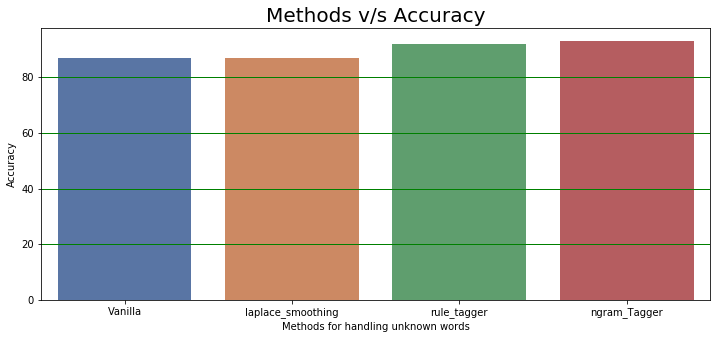

In [35]:
#Plot and check the methods accuracies
plt.figure(figsize=(12,5))
plt.grid(color='g', linestyle='-', linewidth=1)
ax=sns.barplot(x="method", y="accuracy", data=method_accuracy,palette='deep')
ax.axes.set_title("Methods v/s Accuracy",fontsize=20);
ax.set_xlabel("Methods for handling unknown words",fontsize=10);
ax.set_ylabel("Accuracy",fontsize=10);

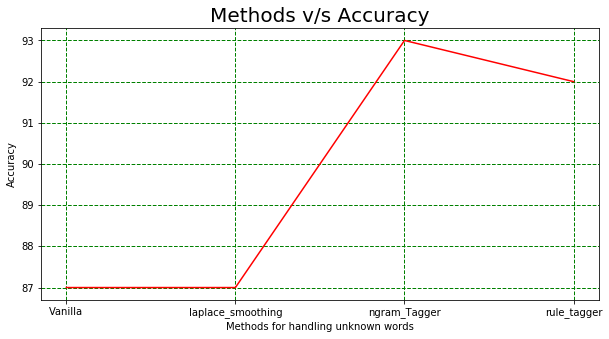

In [36]:
#Plot and check the method accuracies
plt.figure(figsize=(10,5))
plt.grid(color='g', linestyle='-', linewidth=1)
ax = sns.lineplot(x="method", y="accuracy", data=method_accuracy,color='red')
ax.axes.set_title("Methods v/s Accuracy",fontsize=20);
ax.set_xlabel("Methods for handling unknown words",fontsize=10);
ax.set_ylabel("Accuracy",fontsize=10);

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

We have build Three techniques with laplace, rule based tagging and ngram tagger and the following are the some of observations we have seen:

The Laplace smoothing has mostly tagged Nouns correctly when compared to the Vanilla but it failed to tag the verbs and other are incorrectly.
some of the obervations with the laplace smooting are:
    
    android - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    europe - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    donald - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)

The accuracy is jumped from 87% to 92% which is a big leap.Rule based tagging is the best among the methods till now.

    2011, 2013 are now accurately assigned NUM tag (earlier tagged as 'X' by Vanilla)
    modernization is correctly assigned ADJ (earlier tagged as 'X' by Vanilla)
    suddenly is correctly assigned ADV (earlier tagged as 'X' by Vanilla)

The ngram technique ahs tagged Verb and nouns are corrctly when compared to the vanilla viterbi and achieved the accuracy of 93%.
Some of the observations with the ngram technique are:

    arriving - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    contested - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    dallas - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)
